In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import numpy as np

import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import KMNIST
from torchvision import transforms

In [2]:
class CNN_KMnist(nn.Module):
    def __init__(self, input_channel):
        super(CNN_KMnist, self).__init__()

        self.dw1 = nn.Sequential(
            nn.Conv2d(input_channel, 32, kernel_size=5),
            nn.ReLU(),
        )

        self.dw2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5),
            nn.ReLU(),            
        )

        self.up1 = nn.Sequential(
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5) 
        )

        self.up2 = nn.Sequential(            
            nn.ReLU(),
            nn.ConvTranspose2d(32, input_channel, kernel_size=5) 
        )

        self.act = nn.Sigmoid()


    def forward(self, x):
        x = self.dw1(x)
        x= self.dw2(x)
        x = self.up1(x)
        x = self.up2(x)
        x = self.act(x)
        return x

In [3]:
transform = transforms.Compose(
    [
        transforms.ToTensor(), 
        transforms.Normalize((0.1307,), (0.3081,))
    ]
)

trainset = KMNIST(root='~/data',  train=True, download=True, transform=transform)
train_dl = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
testset = KMNIST(root='~/data', train=False, download=True, transform=transform)
test_dl = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

print(len(train_dl), len(test_dl))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18165135/18165135 [00:03<00:00, 4883669.80it/s]


Extracting /home/khoidh/data/KMNIST/raw/train-images-idx3-ubyte.gz to /home/khoidh/data/KMNIST/raw



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29497/29497 [00:00<00:00, 317080.41it/s]


Extracting /home/khoidh/data/KMNIST/raw/train-labels-idx1-ubyte.gz to /home/khoidh/data/KMNIST/raw



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3041136/3041136 [00:01<00:00, 2238583.13it/s]


Extracting /home/khoidh/data/KMNIST/raw/t10k-images-idx3-ubyte.gz to /home/khoidh/data/KMNIST/raw



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5120/5120 [00:00<00:00, 5955306.84it/s]

Extracting /home/khoidh/data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to /home/khoidh/data/KMNIST/raw

1875 313


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu", index = 0)

model = CNN_KMnist(input_channel=1).to(device)

optimizer = Adam(model.parameters(), lr = 0.0001)

loss_fn = nn.MSELoss()

In [5]:
for epoch in range(5):
    model.train()
    tr_total_loss = 0
    for train_img, _ in tqdm(train_dl):
        train_img = train_img.to(device)

        gen_img = model(train_img)
        train_loss = loss_fn(gen_img, train_img)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        tr_total_loss += train_loss.item()

    model.eval()
    with torch.no_grad():
        va_total_loss = 0
        for valid_img, _ in tqdm(test_dl):
            valid_img = valid_img.to(device)

            gen_img = model(valid_img)

            valid_loss = loss_fn(gen_img, valid_img)

            va_total_loss += valid_loss.item()

    print(f"Epoch: {epoch} - TrainLoss: {tr_total_loss/len(train_dl)} - ValidLoss: {va_total_loss/len(test_dl)}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 112.09it/s]


Epoch: 0 - TrainLoss: 0.5869479571501414 - ValidLoss: 0.5385081115812539


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 112.30it/s]


Epoch: 1 - TrainLoss: 0.5594643737792969 - ValidLoss: 0.535538958570066


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:03<00:00, 103.39it/s]


Epoch: 2 - TrainLoss: 0.5578197607040405 - ValidLoss: 0.5343669509164061


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 108.23it/s]


Epoch: 3 - TrainLoss: 0.5570287683010101 - ValidLoss: 0.5337113856126706


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:02<00:00, 107.15it/s]

Epoch: 4 - TrainLoss: 0.5565522888501485 - ValidLoss: 0.5333371418543136


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10.85it/s]


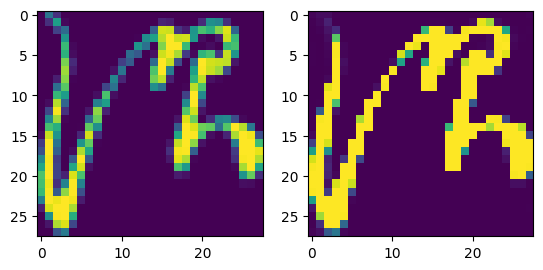

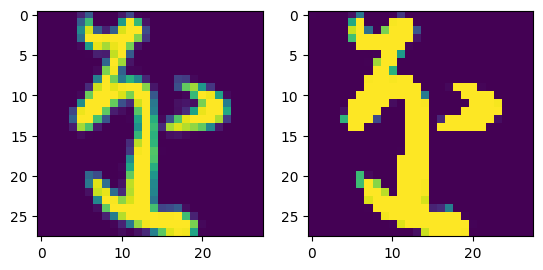

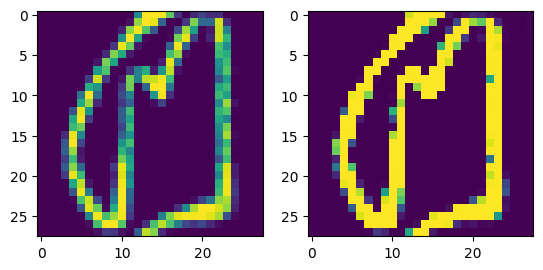

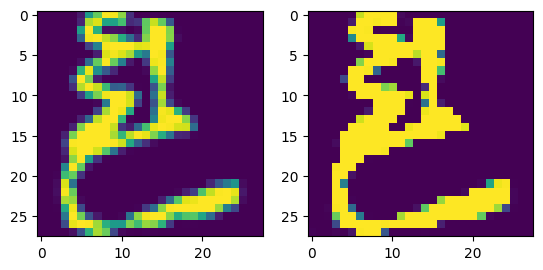

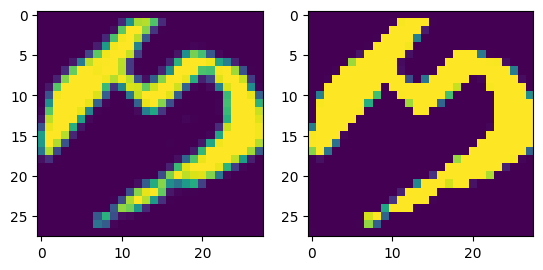

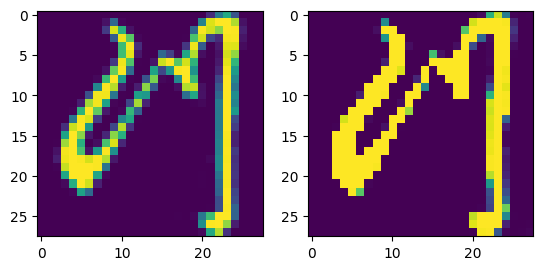

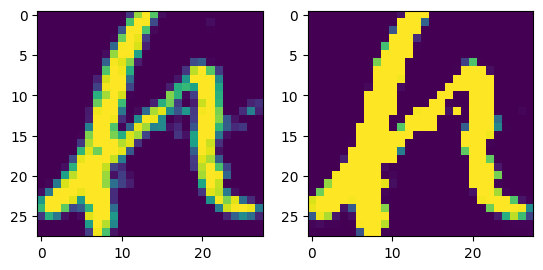

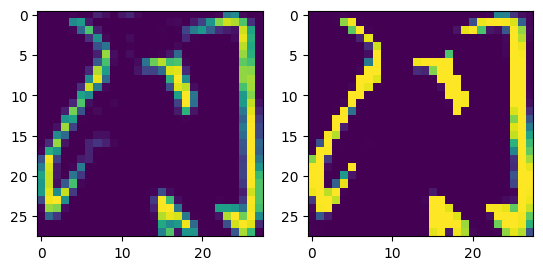

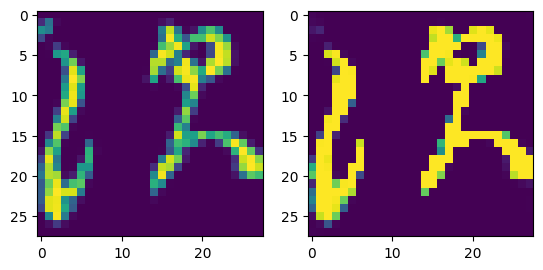

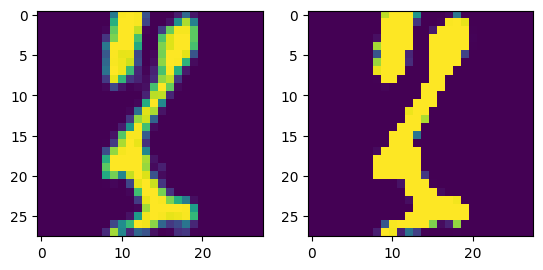

In [6]:
model.eval()
with torch.no_grad():
    for test_case_idx in tqdm(range(10)):
        valid_img, _ = testset[test_case_idx]
        valid_img = valid_img.unsqueeze(dim=0).to(device)

        gen_img = model(valid_img)        

        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(valid_img[0].cpu().permute(1, -1, 0).numpy())
        axarr[1].imshow(gen_img[0].cpu().permute(1, -1, 0).numpy())